# N-Grams, Regex, and TF-IDF

You are an analyst working at McDonalds' corporate headquarters, and charged with identifying areas for improvement to increase customer service.

Using the `mcdonalds-yelp-negative-reviews.csv` dataset, clean and parse the text reviews. Document the decisions you make:
- why remove/keep stopwords?
- stemming versus lemmatization?
- regex cleaning and substitution?
- adding in custom stopwords?

Finally, generate a TF-IDF report that **visualizes** for each city what the major source of complaints with the McDonalds franchises are. Offer your analysis and business recommendations on next steps for the global SVP of Operations.

**Text Processing Notes**

Text data processing include: lower case, tokenizing, drop stopwords, lemmentization, regex cleaning and substitution, and vectorization.

I remove the stopwords to reduce the most common and useless words in text. I include nltk's stopword list and a customized list of variations of word 'McDonald's'. I Use lemmentization over stemming, since it converts the word into its root word, rather than just stripping the suffices. I also use regex to clean the numbers in the words.

In [1]:
import pandas as pd
data = pd.read_csv('mcdonalds-yelp-negative-reviews.csv',encoding='latin-1').set_index('_unit_id')
data.head(3)

city                                             review
_unit_id                                                             
679455653  Atlanta  I'm not a huge mcds lover, but I've been to be...
679455654  Atlanta  Terrible customer service. I came in at 9:30pm...
679455655  Atlanta  First they "lost" my order, actually they gave...

In [2]:
# Clean the text

def clean_text(df,col,my_stopwords):
    # create dropwords list
    from nltk.corpus import stopwords
    stopword = stopwords.words('english')
    stop = stopword + my_stopwords
    
    df[col] = df[col].str.lower() # lower case
    df[col] = df[col].str.replace('\d+','') # remove numbers
    df[col] = df[col].str.replace('[^\w\s]','') # remove punctuations
    df[col] = df[col].apply(lambda x: " ".
                            join(x for x in x.split() 
                                 if x not in stop)) # remove stopwords
    return df

In [3]:
# Tokenize and Lemmatization

def token_lemma(df,col):
    import spacy
    # tokenize by spacy
    nlp = spacy.load('en')
    df['token'] = data[col].apply(lambda x: nlp(x))
    # lemmatize by spacy
    df['lemmatized'] = df['token'].apply(lambda x: " ".join([token.lemma_ for token in x]))
    return df

In [4]:
# Vectorization and tf-idf

def tfidf(df,lb=2,ub=3,max_r=0.4,min_r=1):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from nltk.corpus import stopwords
    vectorizer = TfidfVectorizer(ngram_range=(lb,ub),
                                 token_pattern=r'\b[a-zA-Z]{3,}\b',
                                 max_df=max_r, 
                                 min_df=min_r, stop_words=stopwords.words()) 
    
    corpus = list(df["lemmatized"].values)
    X = vectorizer.fit_transform(corpus)
    terms = vectorizer.get_feature_names()
    tf_idf = pd.DataFrame(X.toarray().transpose(), index=terms)
    tf_idf = tf_idf.sum(axis=1)
    score = pd.DataFrame(tf_idf, columns=["score"])
    score['term'] = terms
    score.sort_values(by="score", ascending=False, inplace=True)
    return score

In [5]:
# Visualizations

def wordcloud_tfidf(df,city):
    import pandas as pd
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import matplotlib.pyplot as plt
    from nltk.corpus import stopwords

    name = city + ' Negative Reviews Cloud'
    name1 = city + '.png'
    
    d = {}
    for a,x in df.values:
        d[x]=a

    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width = 1024,
        height = 720,
        stopwords=stopwords.words("english")
    )
    wc.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name)
    plt.show()
    wc.to_file(name1)

In [6]:
my_stopwords = ['mcds','mcd','mcdonald\'s','mcdonalds','mcdonald']

clean_df = clean_text(data,'review',my_stopwords)
df = token_lemma(clean_df,'review')
df.head(3)

city                                             review  \
_unit_id                                                                
679455653  Atlanta  im huge lover ive better ones far worst one iv...   
679455654  Atlanta  terrible customer service came pm stood front ...   
679455655  Atlanta  first lost order actually gave someone one els...   

                                                       token  \
_unit_id                                                       
679455653  (i, m, huge, lover, i, ve, better, ones, far, ...   
679455654  (terrible, customer, service, came, pm, stood,...   
679455655  (first, lost, order, actually, gave, someone, ...   

                                                  lemmatized  
_unit_id                                                      
679455653  -PRON- be huge lover -PRON- have well one far ...  
679455654  terrible customer service come pm stand front ...  
679455655  first lose order actually give someone one els...

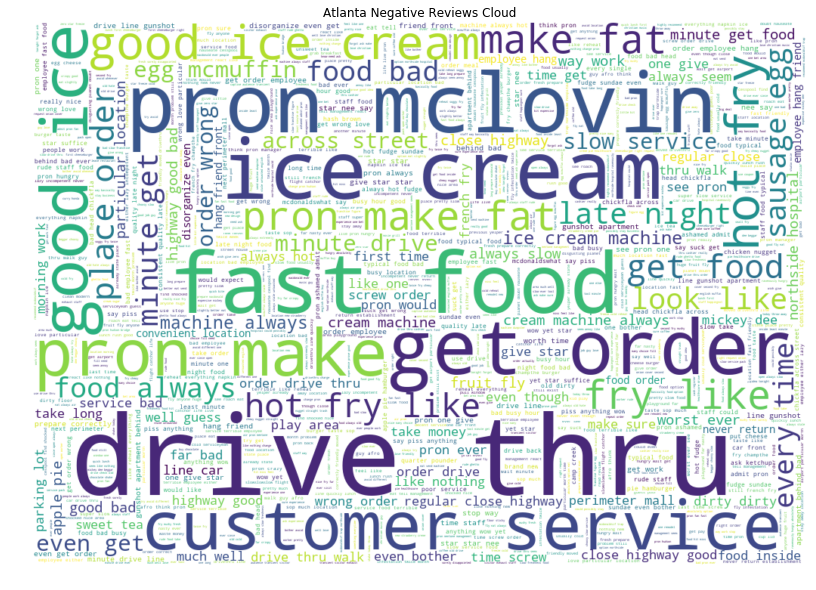

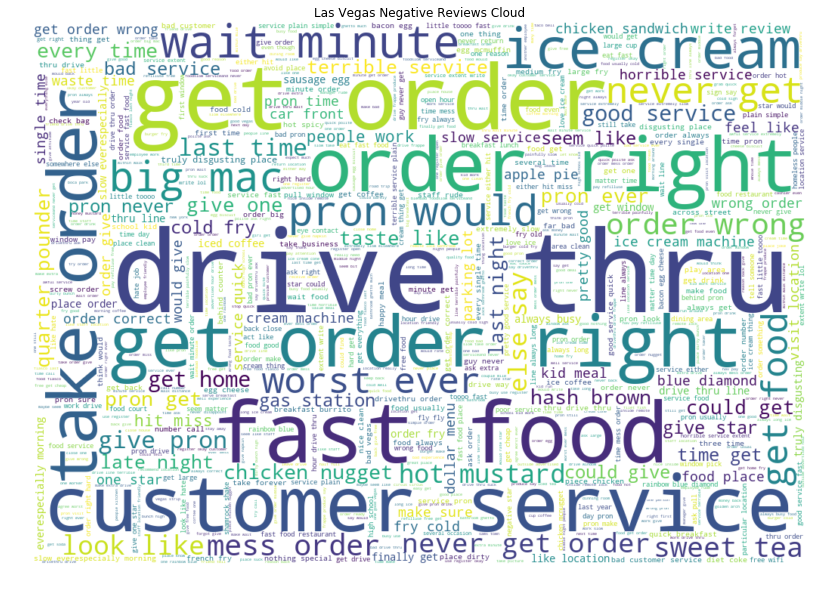

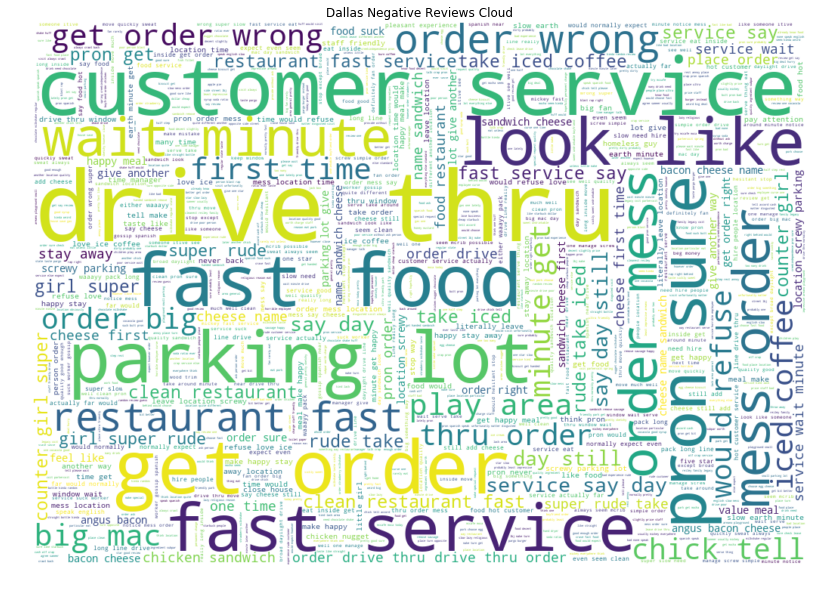

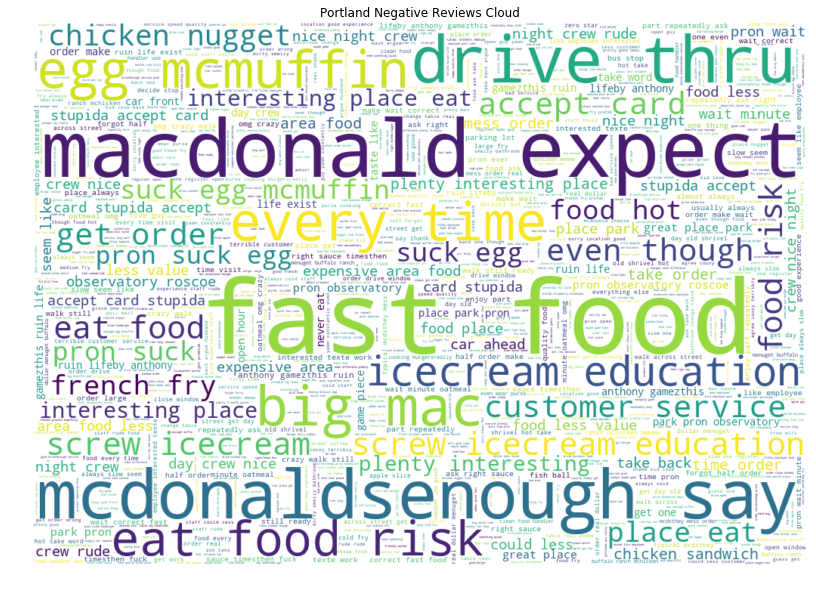

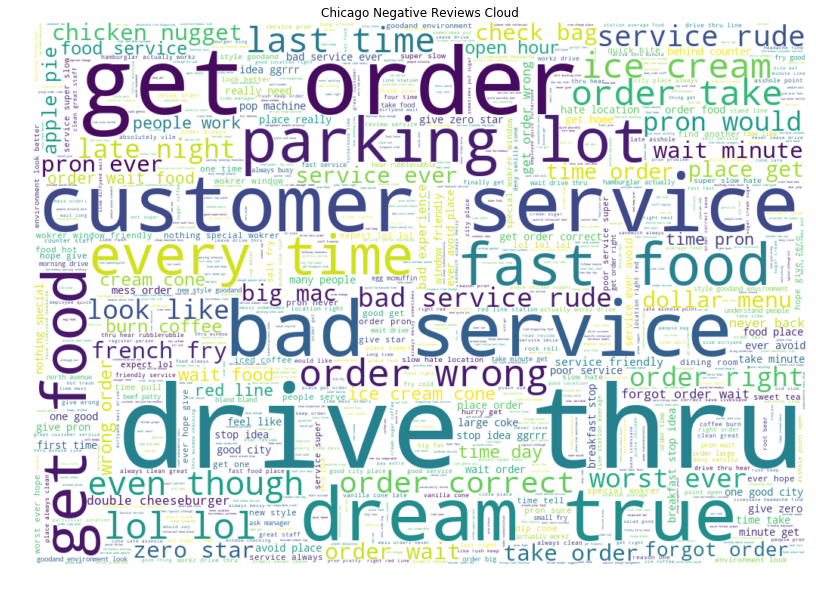

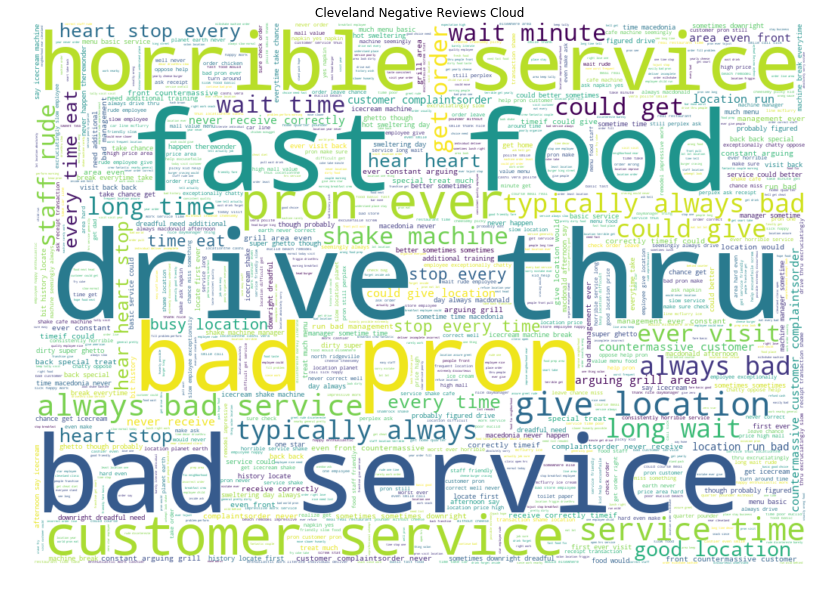

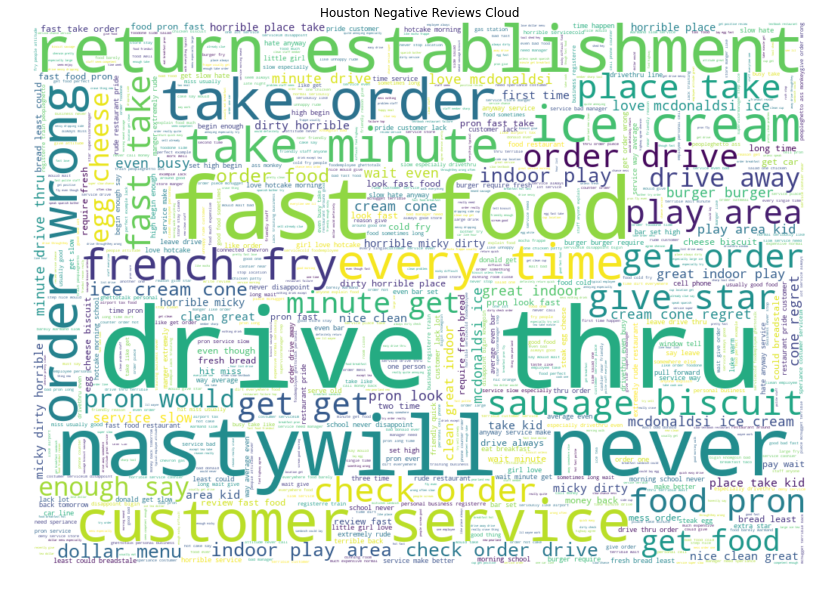

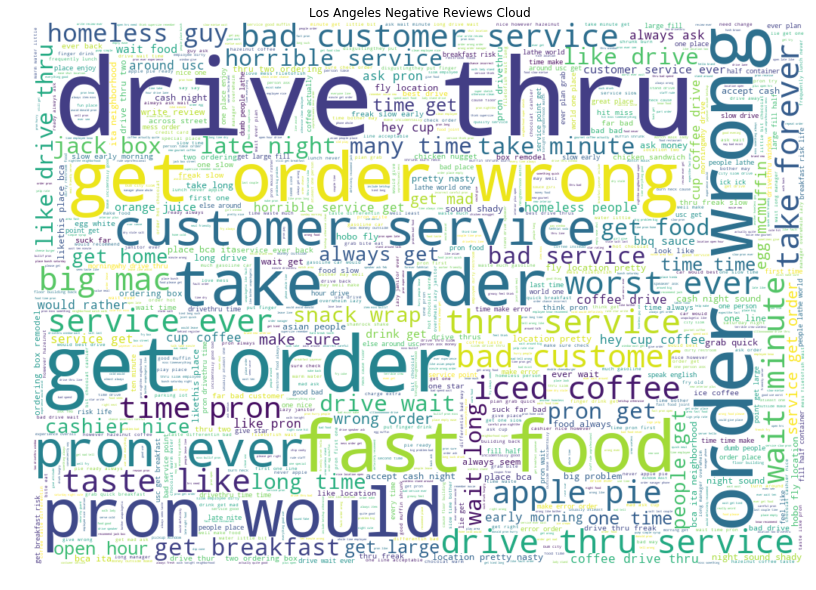

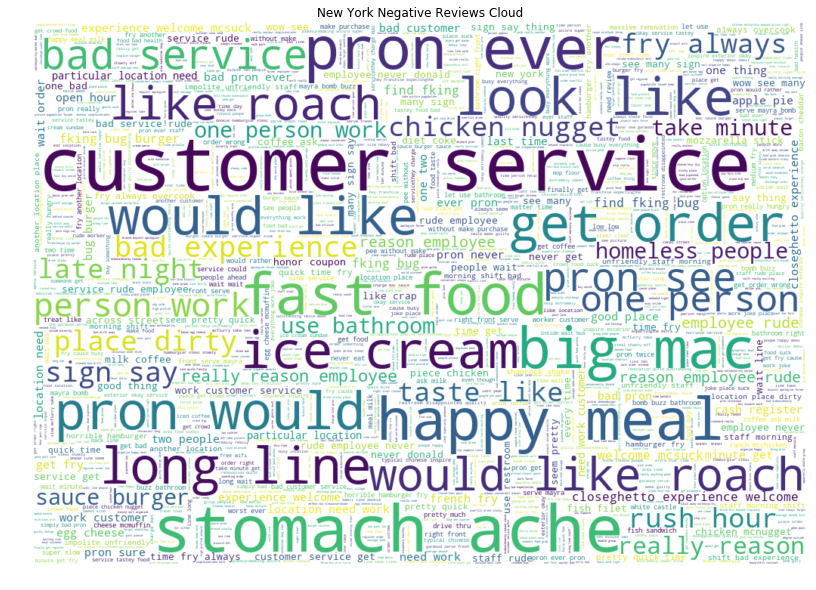

In [8]:
cities = data['city'].dropna().unique().tolist()
for city in cities:
    city_df = df[df['city'] == city]
    score = tfidf(city_df)
    name = 'score'+'_'+city+'.csv'
    score.to_csv(name) # save score file for each city, e.g. 'score_Atlanta.csv'
    wordcloud_tfidf(score,city)

**Business Recommendations**

Given each city's wordcloud, the biggest problem of all is that **all the cities have top poor reviews towards the drive-through**. It yields the management to pay more attention to improve the overall service, since it's not a city-specific case. For each cities, I have some specific suggestions in the following. 

For **Atlanta**, it seems that the **ice cream**, especially the ice cream machine is the major concern. I suggest to sample several stores to check the operation of machine and collect the problems to find ways to improve.

For **Las Vegas**, the problems may lie in the training with ordering staffs, since it reflects that customers always **get the wrong orders and have to wait for long**. I suggest to stress on the training towards staffs in Las Vegas' store.

For **Dallas**, **parking lot** seems to be a big problem. Also, the **order service** seems to be a mess with both wrong order delivery and long waiting time. I suggest to check the capacity and conditions of the parking lot nearby and also pay attention to staff's training.

For **Portland**, the reviews kind of spread but mostly go with **food**, including chicken nuggets, ice cream, french fry, and especially **egg mcmuffin**. I suggest to invest deeper into the food source of eggs, the training of chefs and to check whether the machince should be replaced or mended.

For **Chicago**, apart from problems in orders and parking lot, the complaints lie in **customer services**, saying the service is rude. The training and recruiting should both pay attention.

For **Cleveland**, the reviews are centered to drive thru, bad service and fast food. **Training** also need to be enhanced.

For **Houston**, it also has the problem of **food** especially including ice cream and french fry, which needs more investigation in food making process.

For **Los Angeles**, **order** seems like a big problem apart from drive thru, indicating the management should focus on the training or maybe improve its ordering system and optimize the logistics.

For **New York**, the **cleanliness** appears to be a big problem. The complaints include roach-like creature, dirty places, homeless people, etc. I suggest to perform regular inspection of hygiene conditions.